# Model Training

## Environment Setup

In [1]:
import os
import ssl

if not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)  # GPU memory grows dynamically

print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))
print('GPU Name:', tf.config.experimental.list_physical_devices('GPU')[0])

2024-11-20 13:41:47.504996: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 13:41:47.581090: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available: 1
GPU Name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Parameters

In [3]:
class_names = ['Healthy', 'Phoma', 'Cerscospora', 'Leaf rust', 'Miner']
class_names.sort()

epochs = 100
img_size = (128, 128)
batch_size = 8

## Dataset Generator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1./255, validation_split=.2)

train_gen = data_gen.flow_from_directory(
    directory='dataset_splitted/train',
    subset='training',
    seed=42,
    class_mode='categorical',
    target_size=img_size,
    batch_size=batch_size
)

val_gen = data_gen.flow_from_directory(
    directory='dataset_splitted/train',
    subset='validation',
    seed=42,
    class_mode='categorical',
    target_size=img_size,
    batch_size=batch_size
)

Found 2958 images belonging to 5 classes.
Found 736 images belonging to 5 classes.


## Model Development

### CNN

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Layer, InputLayer, Dropout
from tensorflow.keras.utils import register_keras_serializable


@register_keras_serializable()
class GrayscaleLayer(Layer):
    def call(self, inputs, **kwargs):
        return rgb_to_grayscale(inputs)


def create_cnn_model(name: str, grayscale: bool, dropout: bool) -> Sequential:
    width, height = img_size
    output_len = len(class_names)

    layers = [
        # Input Layer
        InputLayer((width, height, 3), name='Input'),
        # Grayscale conversion layer
        GrayscaleLayer(input_shape=(width, height, 3), name='Grayscale') if grayscale else None,
        # First Conv and MaxPool
        Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv-1'),
        MaxPooling2D((2, 2), name='MaxPool-1'),
        # Second Conv and MaxPool
        Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv-2'),
        MaxPooling2D((2, 2), name='MaxPool-2'),
        # Third Conv and MaxPool
        Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv-3'),
        MaxPooling2D((2, 2), name='MaxPool-3'),
        # Flatten and Fully connected layers
        Flatten(name='Flatten'),
        Dense(512, activation='relu', name='FullyConnected'),
        # Dropout 
        Dropout(.5, name='Dropout') if dropout else None,
        # Output layer
        Dense(output_len, activation='softmax', name='Output')
    ]

    layers = list(filter(None, layers))

    model = Sequential(layers=layers, name=name)

    return model


### ResNet50

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

def create_resnet50_model() -> Sequential:
    width, height = img_size
    output_len = len(class_names)

    # Load the ResNet50 base model
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(width, height, 3)
    )
    base_model.trainable = False  # Freeze the base model

    # Define the full model
    layers = [
            InputLayer((width, height, 3), name='Input'),
            base_model,  # Add the ResNet50 base model
            GlobalAveragePooling2D(name='AvgPool'),  # Global Average Pooling layer
            Dense(512, activation='relu', name='FullyConnected'),  # Fully connected layer
            Dense(output_len, activation='softmax', name='Output')  # Output layer for classification
        ]

    model = Sequential(layers=layers, name='ResNet50')

    return model


### Summarise Models

#### CNN

In [7]:
cnn_model = create_cnn_model('CNN', False, False)
cnn_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv-1 (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 MaxPool-1 (MaxPooling2D)    (None, 64, 64, 32)        0         
                                                                 
 Conv-2 (Conv2D)             (None, 64, 64, 64)        18496     
                                                                 
 MaxPool-2 (MaxPooling2D)    (None, 32, 32, 64)        0         
                                                                 
 Conv-3 (Conv2D)             (None, 32, 32, 128)       73856     
                                                                 
 MaxPool-3 (MaxPooling2D)    (None, 16, 16, 128)       0         
                                                                 
 Flatten (Flatten)           (None, 32768)             0       

2024-11-20 13:42:14.639900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14942 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


#### CNN with grayscaling

In [8]:
cnn_gray_model = create_cnn_model('CNN', True, False)
cnn_gray_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Grayscale (GrayscaleLayer)  (None, 128, 128, 1)       0         
                                                                 
 Conv-1 (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 MaxPool-1 (MaxPooling2D)    (None, 64, 64, 32)        0         
                                                                 
 Conv-2 (Conv2D)             (None, 64, 64, 64)        18496     
                                                                 
 MaxPool-2 (MaxPooling2D)    (None, 32, 32, 64)        0         
                                                                 
 Conv-3 (Conv2D)             (None, 32, 32, 128)       73856     
                                                                 
 MaxPool-3 (MaxPooling2D)    (None, 16, 16, 128)       0       

#### CNN with dropout

In [9]:
cnn_dropout_model = create_cnn_model('CNN', False, True)
cnn_dropout_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv-1 (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 MaxPool-1 (MaxPooling2D)    (None, 64, 64, 32)        0         
                                                                 
 Conv-2 (Conv2D)             (None, 64, 64, 64)        18496     
                                                                 
 MaxPool-2 (MaxPooling2D)    (None, 32, 32, 64)        0         
                                                                 
 Conv-3 (Conv2D)             (None, 32, 32, 128)       73856     
                                                                 
 MaxPool-3 (MaxPooling2D)    (None, 16, 16, 128)       0         
                                                                 
 Flatten (Flatten)           (None, 32768)             0       

#### CNN with grayscaling and dropout

In [10]:
cnn_gray_dropout_model = create_cnn_model('CNN', True, True)
cnn_gray_dropout_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Grayscale (GrayscaleLayer)  (None, 128, 128, 1)       0         
                                                                 
 Conv-1 (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 MaxPool-1 (MaxPooling2D)    (None, 64, 64, 32)        0         
                                                                 
 Conv-2 (Conv2D)             (None, 64, 64, 64)        18496     
                                                                 
 MaxPool-2 (MaxPooling2D)    (None, 32, 32, 64)        0         
                                                                 
 Conv-3 (Conv2D)             (None, 32, 32, 128)       73856     
                                                                 
 MaxPool-3 (MaxPooling2D)    (None, 16, 16, 128)       0       

#### ResNet50

In [11]:
resnet50_model = create_resnet50_model()
resnet50_model.summary()

94765736/94765736 [==============================] - 7s 0us/step
Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 AvgPool (GlobalAveragePool  (None, 2048)              0         
 ing2D)                                                          
                                                                 
 FullyConnected (Dense)      (None, 512)               1049088   
                                                                 
 Output (Dense)              (None, 5)                 2565      
                                                                 
Total params: 24639365 (93.99 MB)
Trainable params: 1051653 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


## Model Training

In [12]:
if not os.path.exists('models'):
    os.mkdir('models')

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, History, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall

def train_model(model: Model) -> History:
    model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    # Training the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, ReduceLROnPlateau(cooldown=3)]
    )

    return history


In [14]:
import matplotlib.pyplot as plt

def plot_history(history: History) -> None:
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


### CNN

#### Train Model

In [15]:
cnn_history = train_model(cnn_model)
cnn_model.save('models/cnn_model.keras')

Epoch 1/100


2024-11-20 13:42:43.942405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-11-20 13:42:44.318691: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa19ae817f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-20 13:42:44.318738: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2024-11-20 13:42:44.401227: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


370/370 [==============================] - 9s 19ms/step - loss: 1.0827 - accuracy: 0.5727 - precision: 0.7613 - recall: 0.3482 - val_loss: 0.5988 - val_accuracy: 0.7677 - val_precision: 0.8477 - val_recall: 0.6957 - lr: 0.0100
Epoch 2/100
370/370 [==============================] - 6s 16ms/step - loss: 0.5938 - accuracy: 0.7958 - precision: 0.8454 - recall: 0.7356 - val_loss: 0.4454 - val_accuracy: 0.8465 - val_precision: 0.8938 - val_recall: 0.8003 - lr: 0.0100
Epoch 3/100
370/370 [==============================] - 6s 16ms/step - loss: 0.3250 - accuracy: 0.8884 - precision: 0.9100 - recall: 0.8682 - val_loss: 0.1366 - val_accuracy: 0.9565 - val_precision: 0.9625 - val_recall: 0.9416 - lr: 0.0100
Epoch 4/100
370/370 [==============================] - 6s 17ms/step - loss: 0.3041 - accuracy: 0.9104 - precision: 0.9263 - recall: 0.8925 - val_loss: 0.1714 - val_accuracy: 0.9443 - val_precision: 0.9555 - val_recall: 0.9334 - lr: 0.0100
Epoch 5/100
370/370 [==============================] - 6

#### History Plot

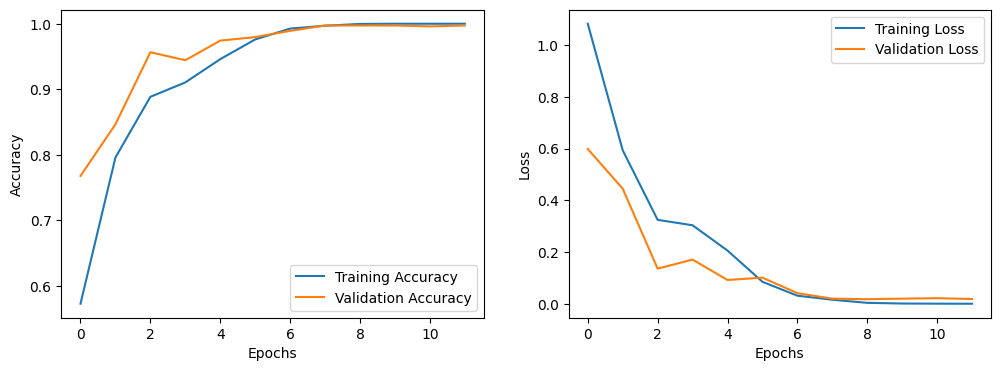

In [16]:
plot_history(cnn_history)

### CNN with grayscaling

#### Train Model

In [17]:
cnn_gray_history = train_model(cnn_gray_model)
cnn_gray_model.save('models/cnn_gray_model.keras')

Epoch 1/100
370/370 [==============================] - 5s 10ms/step - loss: 1.4766 - accuracy: 0.4097 - precision_1: 0.5210 - recall_1: 0.0419 - val_loss: 1.3711 - val_accuracy: 0.4524 - val_precision_1: 0.6157 - val_recall_1: 0.2351 - lr: 0.0100
Epoch 2/100
370/370 [==============================] - 3s 9ms/step - loss: 1.2354 - accuracy: 0.5125 - precision_1: 0.6246 - recall_1: 0.2559 - val_loss: 1.1695 - val_accuracy: 0.4266 - val_precision_1: 0.5783 - val_recall_1: 0.3614 - lr: 0.0100
Epoch 3/100
370/370 [==============================] - 4s 10ms/step - loss: 0.9740 - accuracy: 0.6122 - precision_1: 0.7276 - recall_1: 0.4388 - val_loss: 0.7469 - val_accuracy: 0.6970 - val_precision_1: 0.7706 - val_recall_1: 0.5842 - lr: 0.0100
Epoch 4/100
370/370 [==============================] - 5s 13ms/step - loss: 0.7131 - accuracy: 0.7299 - precision_1: 0.8057 - recall_1: 0.6264 - val_loss: 0.5230 - val_accuracy: 0.8098 - val_precision_1: 0.8581 - val_recall_1: 0.7228 - lr: 0.0100
Epoch 5/100
3

#### History Plot

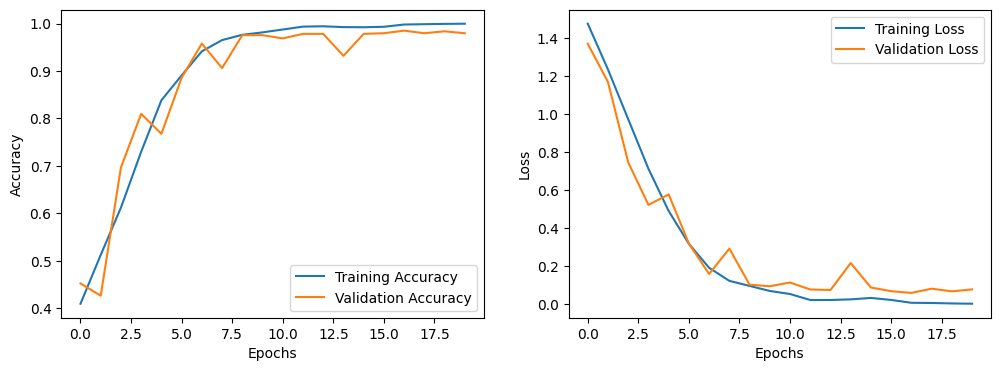

In [18]:
plot_history(cnn_gray_history)

### CNN with dropout

#### Train Model

In [19]:
cnn_dropout_history = train_model(cnn_dropout_model)
cnn_dropout_model.save('models/cnn_dropout_model.keras')

Epoch 1/100
370/370 [==============================] - 7s 17ms/step - loss: 1.2147 - accuracy: 0.5193 - precision_2: 0.7564 - recall_2: 0.2394 - val_loss: 0.8062 - val_accuracy: 0.6685 - val_precision_2: 0.7402 - val_recall_2: 0.5924 - lr: 0.0100
Epoch 2/100
370/370 [==============================] - 6s 16ms/step - loss: 0.7341 - accuracy: 0.7404 - precision_2: 0.8099 - recall_2: 0.6454 - val_loss: 0.4075 - val_accuracy: 0.8573 - val_precision_2: 0.9135 - val_recall_2: 0.8179 - lr: 0.0100
Epoch 3/100
370/370 [==============================] - 6s 16ms/step - loss: 0.4553 - accuracy: 0.8320 - precision_2: 0.8671 - recall_2: 0.7938 - val_loss: 0.2327 - val_accuracy: 0.8940 - val_precision_2: 0.9163 - val_recall_2: 0.8777 - lr: 0.0100
Epoch 4/100
370/370 [==============================] - 6s 16ms/step - loss: 0.3135 - accuracy: 0.8962 - precision_2: 0.9121 - recall_2: 0.8698 - val_loss: 0.1912 - val_accuracy: 0.9293 - val_precision_2: 0.9463 - val_recall_2: 0.9090 - lr: 0.0100
Epoch 5/100


#### History Plot

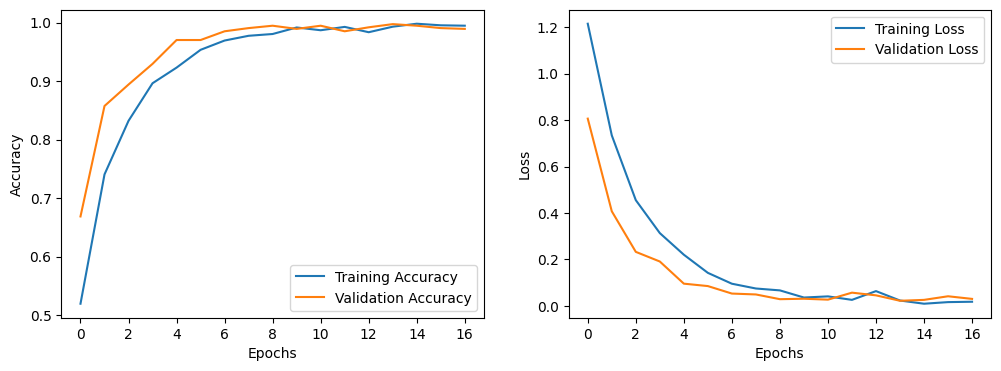

In [20]:
plot_history(cnn_dropout_history)

### CNN with grayscaling and dropout

#### Train Model

In [21]:
cnn_gray_dropout_history = train_model(cnn_gray_dropout_model)
cnn_gray_dropout_model.save('models/cnn_gray_dropout_model.keras')

Epoch 1/100
370/370 [==============================] - 7s 17ms/step - loss: 1.5188 - accuracy: 0.3705 - precision_3: 0.5161 - recall_3: 0.0054 - val_loss: 1.4213 - val_accuracy: 0.4253 - val_precision_3: 0.5852 - val_recall_3: 0.1821 - lr: 0.0100
Epoch 2/100
370/370 [==============================] - 6s 16ms/step - loss: 1.3414 - accuracy: 0.4875 - precision_3: 0.5919 - recall_3: 0.1687 - val_loss: 1.2342 - val_accuracy: 0.5231 - val_precision_3: 0.6039 - val_recall_3: 0.2527 - lr: 0.0100
Epoch 3/100
370/370 [==============================] - 6s 16ms/step - loss: 1.1811 - accuracy: 0.5270 - precision_3: 0.6452 - recall_3: 0.2914 - val_loss: 1.1204 - val_accuracy: 0.5625 - val_precision_3: 0.7005 - val_recall_3: 0.3750 - lr: 0.0100
Epoch 4/100
370/370 [==============================] - 6s 15ms/step - loss: 0.9885 - accuracy: 0.6173 - precision_3: 0.7198 - recall_3: 0.4517 - val_loss: 1.0040 - val_accuracy: 0.6182 - val_precision_3: 0.7209 - val_recall_3: 0.4457 - lr: 0.0100
Epoch 5/100


#### History Plot

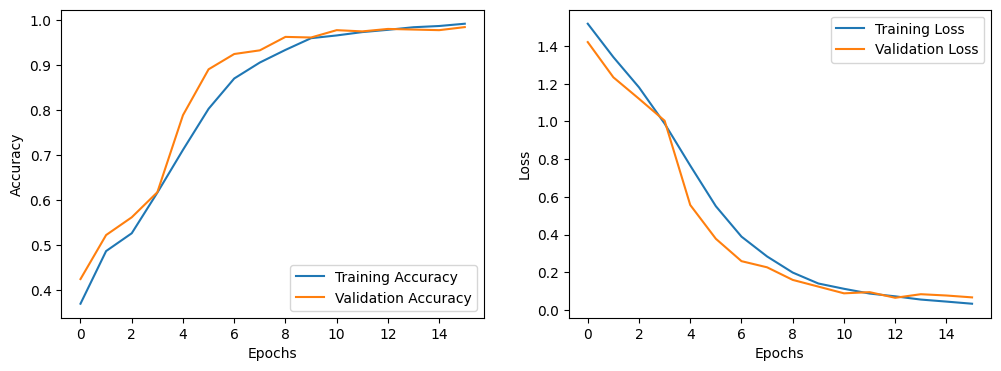

In [22]:
plot_history(cnn_gray_dropout_history)

### ResNet50

#### Train Model

In [23]:
resnet50_history = train_model(cnn_model)
resnet50_model.save('models/resnet50_model.keras')

Epoch 1/100
370/370 [==============================] - 7s 16ms/step - loss: 0.0018 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - val_loss: 0.0208 - val_accuracy: 0.9959 - val_precision_4: 0.9959 - val_recall_4: 0.9959 - lr: 0.0100
Epoch 2/100
370/370 [==============================] - 6s 17ms/step - loss: 0.0013 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - val_loss: 0.0208 - val_accuracy: 0.9973 - val_precision_4: 0.9973 - val_recall_4: 0.9973 - lr: 0.0100
Epoch 3/100
370/370 [==============================] - 6s 17ms/step - loss: 9.0510e-04 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - val_loss: 0.0204 - val_accuracy: 0.9973 - val_precision_4: 0.9973 - val_recall_4: 0.9973 - lr: 0.0100
Epoch 4/100
370/370 [==============================] - 6s 15ms/step - loss: 7.4821e-04 - accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - val_loss: 0.0204 - val_accuracy: 0.9973 - val_precision_4: 0.9973 - val_recall_4: 0.9973 - lr: 0.0100
Epoc

#### History Plot

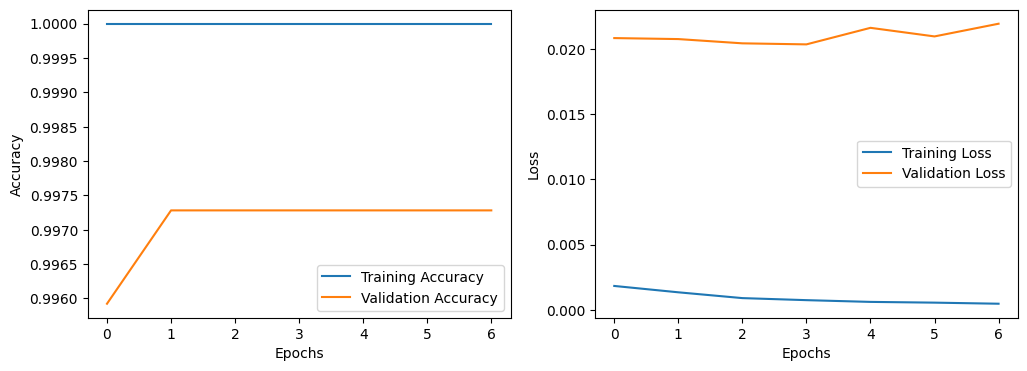

In [24]:
plot_history(resnet50_history)